<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель <br>Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center> Домашнее задание № 10. Решение
## <center> Реализация градиентного бустинга

В этом задании мы реализуем алгоритм градиентного бустинга в довольно общем виде, один и тот же класс будет описывать бинарный классификатор, при обучении которого минимизируется логистическая фунцкция потерь, и 2 регрессора, минимизирующих среднеквадратическую ошибку MSE и [RMSLE](https://www.kaggle.com/wiki/RootMeanSquaredLogarithmicError). Это даст представление о том, что с помощью градиентного бустинга можно оптимизировать произвольные дифференцируемые функции потерь, а также что бустинг адаптируется под разные задачи. [Веб-форма](https://goo.gl/forms/mMUhGSDiOHJI9NHN2) для ответов.

Версию алгоритма берем из [статьи](https://habrahabr.ru/company/ods/blog/327250/#klassicheskiy-gbm-algoritm-friedman-a) (см. псевдокод), но с двумя упрощениями:
- инициализация – средним значением вектора $\large y$, то есть $\large \hat{f_0} = \frac{1}{n}\sum_{i=1}^{n}y_i$
- шаг градиентного спуска (то же что и вес очередного базового алгоритма в композиции) постоянный: $\large \rho_t = const$

Соответствие обозначений в псевдокоде и в классе `GradientBoosting`, который мы сейчас напишем:
- $\large \{x_i, y_i\}_{i = 1,\ldots n}$ или `X`, `y` – обучающая выборка
- $\large L(y,f)$ или `objective` – функция потерь
- $\large \frac{\partial L(y_i,f(x_i))}{\partial f(x_i)}$ или `objective_grad` – градиент функции потерь
- $М$ или `n_estimators` – число итераций бустинга
- $\large h(x,\theta)$ или `DecisionionTreeRegressor` – базовый алгоритм, дерево решений для регрессии
- $\large \theta$ – гиперпараметры деревьев, мы рассмотрим только `max_depth` и `random_state`
- $\large \rho_t$ или `learning_rate` – коэффициент, с которым  $\large h_t(x,\theta)$ входит в композицию, $t=1,\ldots,M$

## Вычисление градиентов log_loss, MSE и RMSLE

Для начала классика – возьмем ручку и бумажку и посчитаем градиенты функций потерь:

$$log\_loss(y, p) = -y\log p - (1 - y)\log (1 - p) = -\sum_{i=1}^{n}y_i\log p_i + (1 - y_i)\log (1 - p_i)$$

$$MSE(y, p) = \frac{1}{n}(y - p)^T(y - p) = \frac{1}{n}\sum_{i=1}^{n}(y_i - p_i)^2$$

$$RMSLE(y, p) = \sqrt{\frac{1}{n} (\log (p + 1) - \log (y + 1))^T(\log (p + 1) - \log (y + 1))} = \sqrt{\frac{1}{n} \sum_{i=1}^{n}(\log (p_i + 1) - \log (y_i + 1))^2}$$

Здесь $y$ и $p$ – это **векторы** истинных ответов и прогнозов соответственно.
`log_loss` взяли как в  `sklearn` – для случая меток целевого класса 0 и 1, а не -1 и 1, как описано в статье (только не усреднили, т.е. нет деления на число объектов $n$, в `sklearn` это соответствует значению аргумента `normalize=False` функции `log_loss`).

<font color='red'>Вопрос 1.</font> Какова формула градиента функции `MSE`?
 <br><br>
 1. $(p - y) \hspace{5cm}$ 3. $2(p - y)$
 <br><br>
 2. $\frac{2}{n}(y - p) \hspace{4.7cm}$ 4. $\frac{2}{n}(p - y)$
  <br><br>
 <font color='red'>Ответ: 4.</font>
 
 <font color='red'>Решение.</font>$\large \frac{\partial}{\partial p_i} MSE = \frac{1}{n} * 2(y_i-p_i)*(-1) = \frac{2}{n}(p_i - y_i)$. Тогда $\large \nabla MSE = \frac{2}{n}(p - y)$.

<font color='red'>Вопрос 2.</font> Какова формула градиента функции `log_loss`? <br>

 1. $\large \frac{y - p}{y(1 - y)} \hspace{5.2cm}$ 3. $\large \frac{p - y}{p(1 - p)}$
 <br><br>
 2. $\large \frac{y - p}{p(1 - p)}\hspace{5.2cm}$ 4. $\large \frac{p - y}{y(1 - y)}$
 <br><br>
 *Примечание:* деление на вектор – покомпонентное, например $\frac{1}{p} = (\frac{1}{p_1}, \ldots \frac{1}{p_n})^T$
 
   <br><br>
 <font color='red'>Ответ: 3.</font>
 
<font color='red'>Решение.</font>$\large \frac{\partial}{\partial p_i} log\_loss = -\frac{y_i}{p_i} + \frac{1 - y_i}{1 - p_i}(-1) = \frac{p_i - y_i}{p_i(1 - p_i)}$. Тогда $\large \nabla log\_loss = \frac{p - y}{p(1 - p)}$.

<font color='red'>Вопрос 3.</font> Какова формула градиента функции `RMSLE`? <br>
 1. $\frac{1}{n}~(p + 1)~RMSLE^{-1}(y, p) \log \frac{p+1}{y+1} \hspace{5cm}$ 3. $[n~(y + 1)~RMSLE(y, p)]^{-1} \log \frac{p+1}{y+1} $
 <br><br>
 2. $[n~(p + 1)~RMSLE(y, p)]^{-1} \log \frac{p+1}{y+1} \hspace{5cm}$ 4. $\frac{1}{n}~\frac{y+1}{(p + 1)}~RMSLE^{-1}(y, p) \log \frac{p+1}{y+1}$
 
   <br><br>
 <font color='red'>Ответ: 2.</font><br>
 
 <font color='red'>Решение.</font> $ \frac{\partial}{\partial p_i} RMSLE = \frac{1}{2\sqrt{\ldots}} \frac{1}{n}2(\log{(p_i+1)} - \log{(y_i+1)})\frac{1}{p_i+1} = [n~(p_i + 1)~RMSLE]^{-1} \log \frac{p_i+1}{y_i+1}$<br>
 Тогда $\nabla RMSLE = [n~(p + 1)~RMSLE(y, p)]^{-1} \log \frac{p+1}{y+1} $

## Реализация алгоритма

Напишем класс `GradientBoosting`. Детали:
- класс наследуется от `sklearn.base.BaseEstimator`;
- конструктор принимает параметры `loss` – название фунцкии потерь, которая будет оптимизироваться (`log_loss`, `mse` (по умолчанию) или `rmsle`), `n_estimators` – число деревьев (т.е. число итераций бустинга, по умолчанию – 10), `learning_rate` – шаг градиентного спуска (по умолчанию $10^{-2}$), `max_depth` – ограничение на максимальную глубину деревьев (по умолчанию 3) и `random_state` – сид генерации псевдослучайных чисел, нужен только для деревьев (по умолчанию 17);
- в зависимости от переданного значения `loss` инициализируются `objective` и `objective_grad`. Для `MSE` берем `sklearn.metrics.mean_squared_error`, для `log_loss` – `sklearn.metrics.log_loss` (без нормализации, то есть на число объектов не надо делить, формула дана выше), а `RMSLE` и градиенты всех трех функций надо реализовать самостоятельно. При подсчете градиентов не выкидывайте константы типа двойки или $n$;
- в реализациях градиентов `log_loss` и `rmsle` будет покомпонентное деление на вектора. Чтобы избежать деление на 0, предварительно замените значения, меньшие $10^{-5}$, на $10^{-5}$. Но только там, где необходимо. Например, в случае вычисления $\frac{y}{p}$ замены делаем только в векторе $p$;
- также в конструкторе создаются списки `loss_by_iter_` и `residuals_by_iter_` для отлаживания работы алгоритма и `trees_` – для хранения обученных деревьев;
- класс имеет методы `fit`, `predict` и `predict_proba`
- метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`), а возвращает текущий экземпляр класса `GradientBoosting`, т.е. `self`. Основная логика, конечно же, реализуется здесь. На каждой итерации текущее значение функции потерь записывается в `loss_by_iter_`, значение антиградиента (то что в статье названо псевдо-остатками) – в `residuals_by_iter_` (можно в конструктор добавить флаг `debug=False` и добавлять значения антиградиента только при включенном флаге). Также обученное дерево добавляется в список `trees_`;
- метод `predict_proba` возвращает линейную комбинацию прогнозов деревьев. Не забудем тут и про начальное приближение. В случае регрессии название метода будет не очень удачным, но оставим так, чтоб не писать отдельно классификатор и регрессор. В случае классификации к ответу применяется $\sigma$-преобразование. В реализации $\sigma$-функции замените значения аргумента, превышающие по модулю 100, на -100 или +100 в зависимости от знака (чтоб избежать underflow & overflow);
- метод `predict` в случае регрессии возвращает линейную комбинацию прогнозов деревьев (+ начальное приближение), то есть то же, что и `predict_proba`. В случае классификации метод `predict` задействует метод `predict_proba` и возвращает вектор из 0 и 1, полученный сравнением предсказанных вероятностей с некоторым порогом, при котором максимизируется доля правильных ответов на обучающей выборке. Здесь хорошо было бы решить одномерную задачу оптимизации, но для полной воспроизводимости давайте выбирать порог из `np.linspace(0.01, 1.01, 100)`.

In [1]:
import numpy as np
from tqdm import tqdm_notebook
from sklearn.base import BaseEstimator
from sklearn.metrics import log_loss, mean_squared_error, roc_auc_score, accuracy_score
from sklearn.datasets import load_breast_cancer, load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
class GradientBoosting(BaseEstimator):
    
    def sigma(self, z):
        z = z.reshape([z.shape[0], 1])
        z[z > 100] = 100
        z[z < -100] = -100
        return 1. / (1 + np.exp(-z))

    def log_loss_grad(self, y, p):
        y = y.reshape([y.shape[0], 1])
        p = p.reshape([p.shape[0], 1])
        p[p < 1e-5] = 1e-5
        p[p > 1 - 1e-5] = 1 - 1e-5
        return (p - y) / p / (1 - p) 
    
    def mse_grad(self, y, p):
        return 2 * (p - y.reshape([y.shape[0], 1])) / y.shape[0]
    
    def rmsle(self, y, p):
        y = y.reshape([y.shape[0], 1])
        p = p.reshape([p.shape[0], 1])
        return np.mean(np.log((p + 1) / (y + 1))** 2) ** 0.5
    
    def rmsle_grad(self, y, p):
        y = y.reshape([y.shape[0], 1])
        p = p.reshape([p.shape[0], 1])
        return 1. / (y.shape[0] * (p + 1) * self.rmsle(y, p)) * np.log((p + 1) / (y + 1)) 
    
    
    def __init__(self, n_estimators=10, learning_rate=0.01,
                 max_depth=3, random_state=17,
                loss='mse', debug=False):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.learning_rate = learning_rate
        self.loss_name = loss
        self.initialization = lambda y: np.mean(y) * np.ones([y.shape[0], 1])
        self.debug = debug
        
        if loss == 'log_loss':
            self.objective = log_loss
            self.objective_grad = self.log_loss_grad
        elif loss == 'mse':
            self.objective = mean_squared_error
            self.objective_grad = self.mse_grad
        elif loss == 'rmsle':
            self.objective = self.rmsle
            self.objective_grad = self.rmsle_grad
        elif loss == 'rmspe':
            self.objective = rmspe
            self.objective_grad = self.rmspe_grad
        
        self.trees_ = []
        self.loss_by_iter = []
        
        if self.debug:
            self.residuals = []
            self.temp_pred = []
    
    def fit(self, X, y):
        self.X = X
        self.y = y
        b = self.initialization(y)
     
        prediction = b.copy()
        
        for t in range(self.n_estimators):

            resid = - self.objective_grad(y, prediction)
            
            # чтобы разобраться с алгоритмом на игрушечных примерах (debug=True),
            # будем смотреть на остатки (антиградиент) на каждой итерации
            if self.debug:    
                self.residuals.append(resid)
            
            # обучаем дерево-регрессор на остатки
            tree = DecisionTreeRegressor(max_depth=self.max_depth,
                                         random_state=self.random_state)
            tree.fit(X, resid)
            
            b = tree.predict(X).reshape([X.shape[0], 1])
            
            # для отладки может пригодиться прогноз на каждой итерации
            if self.debug: 
                self.temp_pred.append(b)
                
            self.trees_.append(tree)
            
            prediction += self.learning_rate * b
                
            self.loss_by_iter.append(self.objective(y, prediction))
        
        # сохраним прогноз алгоритма на той выборке, на которой он обучался
        self.train_pred = prediction
        
        # в случае log_loss еще применим сигмоид-преобразование, чтоб вернуть вероятности 
        # т.е. оценку принадлежности к положительному классу
        if self.loss_name == 'log_loss':
            self.train_pred = self.sigma(self.train_pred)
        
        return self
         
        
    def predict_proba(self, X):
        
        # сначала прогноз – это просто вектор из средних значений ответов на обучении
#         pred = self.initialization(self.y)
        pred = np.ones([X.shape[0], 1]) * np.mean(self.y)
        
        # добавляем прогнозы деревьев
        for t in range(self.n_estimators):
            pred += self.learning_rate * self.trees_[t].predict(X).reshape([X.shape[0], 1])
            
        # в случае log_loss еще применим сигмоид-преобразование, чтоб вернуть вероятности 
        if self.loss_name == 'log_loss':
            return self.sigma(pred)
        else:
            return pred 
        
    def predict(self, X):
        
        pred_probs = self.predict_proba(X)
        
        # при классификации, чтоб из веротяностей получить бинарные ответы (метки классов), выберем
        # тот порог, при котором accuracy максимальна
        if self.loss_name == 'log_loss':
            max_accuracy = 0 
            best_thres = 0
            for thres in np.linspace(0.01, 1.01, 100):
                acc = accuracy_score(self.y, self.train_pred > thres)
                if acc > max_accuracy:
                    max_accuracy = acc
                    best_thres = thres
            return pred_probs > best_thres
        else:
            # это не очень красиво, но в случае регрессии predict будет вызывать predict_proba и возвращать
            # то же самое. Конечно, при регресии никаких вероятностей не будет, но это делается чтоб не писать
            # отдельно классификатор и регрессор как отдельные классы. Хотя можно их сделать наследниками 
            # GradientBoosting
            return pred_probs

Вспомогательные функции

In [3]:
def get_1d_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    return np.arange(x_min, x_max, eps)

In [4]:
def get_2d_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, eps),
                         np.arange(y_min, y_max, eps))

## Регрессия с игрушечным примером

In [5]:
X_regr_toy = np.arange(7).reshape(-1, 1)
y_regr_toy = ((X_regr_toy - 3) ** 2).astype('float64')

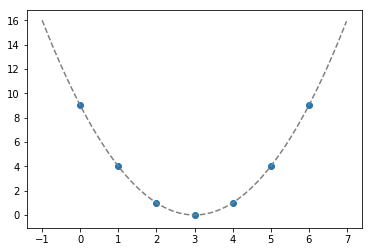

In [6]:
xx = get_1d_grid(X_regr_toy)
plt.plot(xx, ((xx - 3) ** 2).astype('float64'), color='gray', linestyle='--')
plt.scatter(X_regr_toy, y_regr_toy);

Обучите регрессор `GradientBoosting` с функцией потерь `MSE` и параметрами `learning_rate`=0.1,  `max_depth`=3 - 200 итераций. Посмотрите на изменение функции потерь по итерациям бустинга. Можно также посмотреть на приближение и остатки на первых нескольких итерациях, как это делалось в статье.

Обучите регрессор `GradientBoosting` с теми же параметрами, но функцию потерь измените на `RMSLE`. Посмотрите на те же картинки. 

In [7]:
boost_regr_mse = GradientBoosting(n_estimators=200, loss='mse', max_depth=3,
                             learning_rate=0.1, debug=True)

In [8]:
boost_regr_mse.fit(X_regr_toy, y_regr_toy);

**Финальный прогноз композиции**<br>
Налицо проблема деревьев (и, соответственно, случайного леса и бустинга) – они не умеют экстраполировать. Умеют только интерполировать. В данном случае прогноз вне интервала $[0,6]$ будет константным.

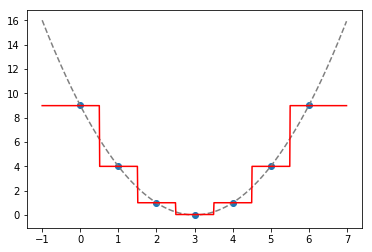

In [9]:
xx = get_1d_grid(X_regr_toy)
plt.plot(xx, ((xx - 3) ** 2), color='gray', linestyle='--')
plt.scatter(X_regr_toy, y_regr_toy);
plt.plot(xx, boost_regr_mse.predict(xx.reshape([xx.shape[0], 1])), color='red');

**Остатки на каждой итерации и соответствующий прогноз очередного дерева**

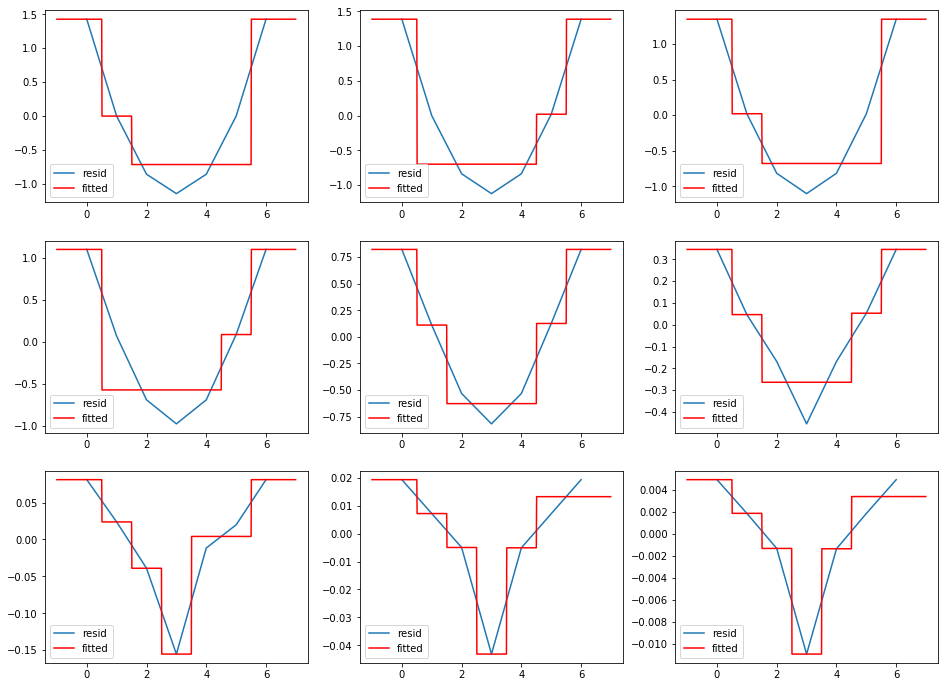

In [10]:
plt.rcParams['figure.figsize'] = (16, 12)

plt.subplots(3,3)

for i, tree_idx in enumerate([1, 2, 3, 10, 20, 50, 
                 100, 150, 200], 1):
    plt.subplot(3, 3, i)
    plt.plot(X_regr_toy, boost_regr_mse.residuals[tree_idx - 1], label='resid')
    plt.plot(xx, boost_regr_mse.trees_[tree_idx- 1].predict(xx.reshape([xx.shape[0], 1])), 
             color='red', label='fitted');
    plt.legend();

**Изменение прогноза всей композиции при увеличении числа деревьев.**

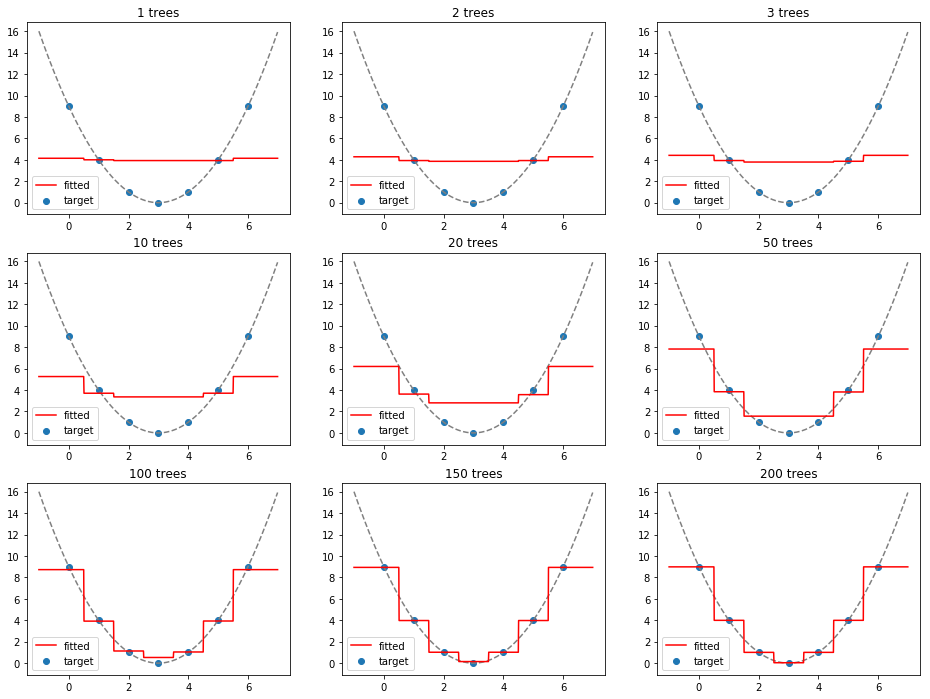

In [11]:
plt.subplots(3,3)

for i, n_trees in enumerate([1, 2, 3, 10, 20, 50, 
                 100, 150, 200], 1):
    plt.subplot(3, 3, i)
    
    boost_regr = GradientBoosting(n_estimators=n_trees, loss='mse', max_depth=3,
                             learning_rate=0.1, debug=True)
    boost_regr.fit(X_regr_toy, y_regr_toy);
    
    plt.plot(xx, ((xx - 3) ** 2), color='gray', linestyle='--')
    plt.scatter(X_regr_toy, y_regr_toy, label='target');
    plt.plot(xx, boost_regr.predict(xx.reshape([xx.shape[0], 1])), 
             color='red', label='fitted');
    plt.legend()
    plt.title('%s trees' % str(n_trees));

**Падение MSE по итерациям бустинга.**

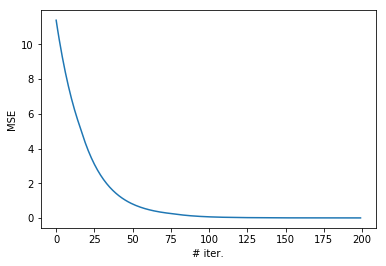

In [12]:
plt.rcParams['figure.figsize'] = (6, 4)
plt.plot(range(len(boost_regr_mse.loss_by_iter)), boost_regr_mse.loss_by_iter);
plt.xlabel('# iter.')
plt.ylabel('MSE');

**Теперь то же самое, но с функцией потерь RMSLE.**

In [13]:
boost_regr_rmsle = GradientBoosting(n_estimators=200, loss='rmsle', max_depth=3,
                             learning_rate=0.5, debug=True)

In [14]:
boost_regr_rmsle.fit(X_regr_toy, y_regr_toy);

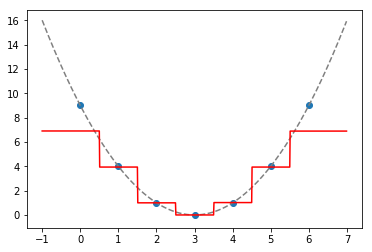

In [15]:
xx = get_1d_grid(X_regr_toy)
plt.plot(xx, ((xx - 3) ** 2), color='gray', linestyle='--')
plt.scatter(X_regr_toy, y_regr_toy);
plt.plot(xx, boost_regr_rmsle.predict(xx.reshape([xx.shape[0], 1])), color='red');

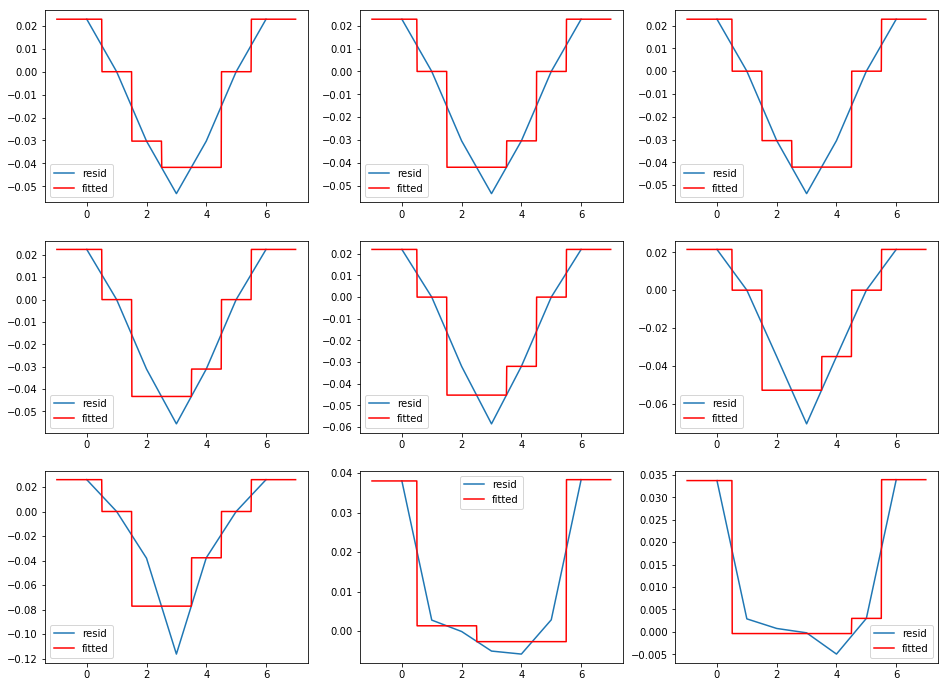

In [16]:
plt.rcParams['figure.figsize'] = (16, 12)

plt.subplots(3,3)

for i, tree_idx in enumerate([1, 2, 3, 10, 20, 50, 
                 100, 150, 200], 1):
    plt.subplot(3, 3, i)
    plt.plot(X_regr_toy, boost_regr_rmsle.residuals[tree_idx - 1], label='resid')
    plt.plot(xx, boost_regr_rmsle.trees_[tree_idx- 1].predict(xx.reshape([xx.shape[0], 1])), 
             color='red', label='fitted');
    plt.legend();

**Изменение прогноза всей композиции при увеличении числа деревьев.**

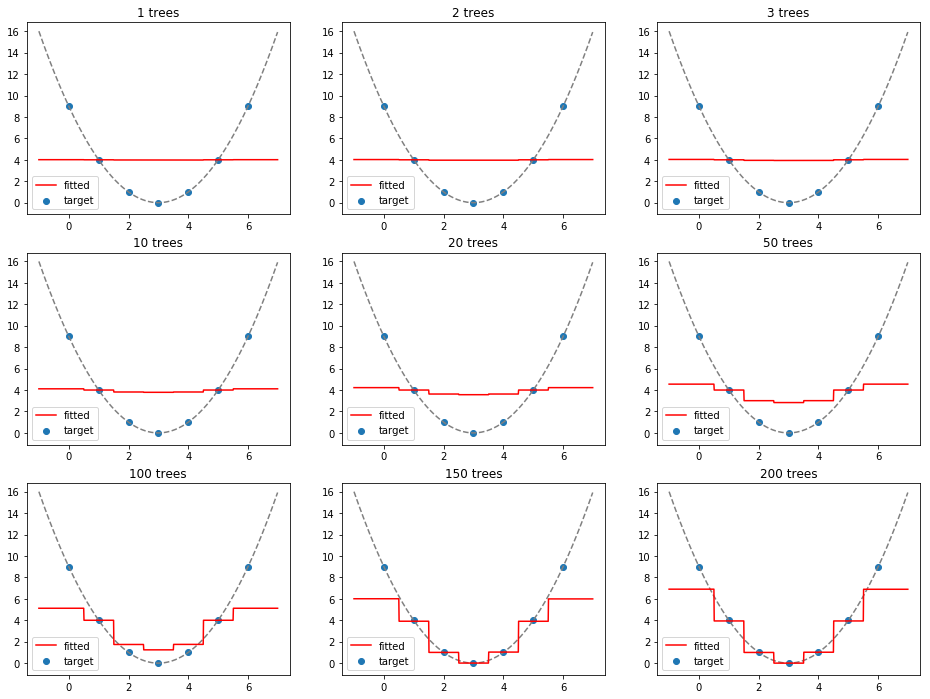

In [17]:
plt.subplots(3,3)

for i, n_trees in enumerate([1, 2, 3, 10, 20, 50, 
                 100, 150, 200], 1):
    plt.subplot(3, 3, i)
    
    boost_regr = GradientBoosting(n_estimators=n_trees, loss='rmsle', max_depth=3,
                             learning_rate=0.5)
    boost_regr.fit(X_regr_toy, y_regr_toy);
    
    plt.plot(xx, ((xx - 3) ** 2), color='gray', linestyle='--')
    plt.scatter(X_regr_toy, y_regr_toy, label='target');
    plt.plot(xx, boost_regr.predict(xx.reshape([xx.shape[0], 1])), 
             color='red', label='fitted');
    plt.legend()
    plt.title('%s trees' % str(n_trees));

**Падение RMSLE по итерациям бустинга.**

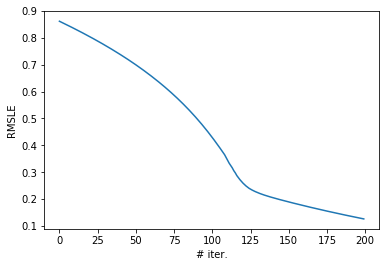

In [18]:
plt.rcParams['figure.figsize'] = (6, 4)
plt.plot(range(len(boost_regr_rmsle.loss_by_iter)), boost_regr_rmsle.loss_by_iter);
plt.xlabel('# iter.')
plt.ylabel('RMSLE');


## Классификация с игрушечным примером

In [19]:
X_clf_toy = np.c_[np.arange(7), (np.arange(7) - 3) ** 2]
y_clf_toy = np.array([0, 1, 0, 1, 0, 1, 0])

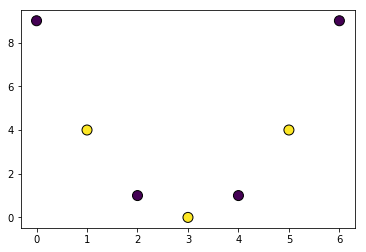

In [20]:
plt.scatter(X_clf_toy[:, 0], X_clf_toy[:, 1], c=y_clf_toy,
            s=100, edgecolors='black', linewidth=1);

In [21]:
boost_clf = GradientBoosting(n_estimators=10, loss='log_loss', max_depth=3,
                             learning_rate=0.05)

In [22]:
boost_clf.fit(X_clf_toy, y_clf_toy)

GradientBoosting(debug=False, learning_rate=0.05, loss=None, max_depth=3,
         n_estimators=10, random_state=17)

In [23]:
clf_pred_probs = boost_clf.predict_proba(X_clf_toy)

**Финальный прогноз композиции**<br>
Пожалуй, пример оказался не особо интересным.

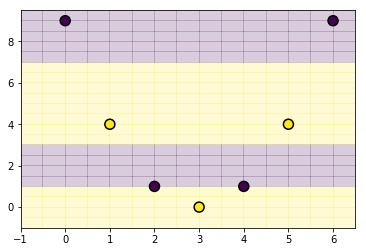

In [24]:
xx, yy = get_2d_grid(X_clf_toy, eps=0.5)
predicted = boost_clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='viridis', alpha=0.2)
plt.scatter(X_clf_toy[:, 0], X_clf_toy[:, 1], c=y_clf_toy, s=100,
            cmap='viridis', edgecolors='black', linewidth=1.5);

Рисовать то, как по итерациям менялась разделяющая поверхность, в данном случае не стоит – на глаз изменений не видно. Возьмем два примера – самый левый (фиолетовый, класс 0) и второй слева (желтый, класс 1). Посмотрим, как для этих двух примеров меняется предсказанная вероятность отнесения к классу + при увеличении числа деревьев. 

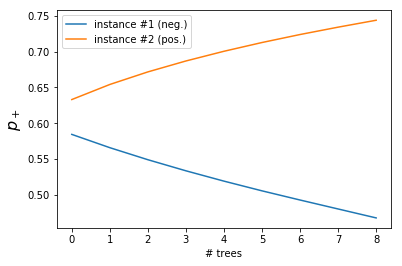

In [25]:
plt.rcParams['figure.figsize'] = (6, 4)

pred_probs1_by_tree, pred_probs2_by_tree = [], []

for i in range(9):
    boost_clf_ = GradientBoosting(n_estimators=i+1, loss='log_loss', max_depth=3,
                             learning_rate=0.05).fit(X_clf_toy, y_clf_toy)
    pred_probs1_by_tree.append(boost_clf_.predict_proba(X_clf_toy)[0])
    pred_probs2_by_tree.append(boost_clf_.predict_proba(X_clf_toy)[1])
plt.plot(pred_probs1_by_tree, label='instance #1 (neg.)')
plt.plot(pred_probs2_by_tree,  label='instance #2 (pos.)')
plt.xlabel('# trees')
plt.ylabel(r'$p_+$', fontsize=16)
plt.legend();

**Падение `log_loss` по итерациям бустинга.**

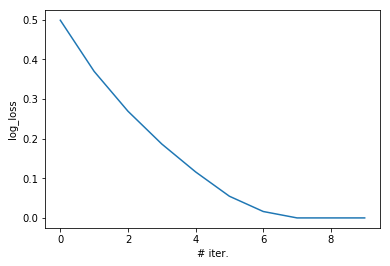

In [26]:
plt.plot(range(len(boost_clf.loss_by_iter)), boost_clf.loss_by_iter);
plt.xlabel('# iter.')
plt.ylabel('log_loss');

In [27]:
clf_pred_probs

array([[ 0.45554883],
       [ 0.75303888],
       [ 0.45554883],
       [ 0.75303888],
       [ 0.45554883],
       [ 0.75303888],
       [ 0.45554883]])

Обучите классификатор `GradientBoosting` с функцией потерь `log_loss` и параметрами `learning_rate`=0.05,  `max_depth`=3 – 10 итераций. Посмотрите на изменение функции потерь по итерациям бустинга. Можно также посмотреть на приближение и остатки на первых нескольких итерациях, как это делалось в статье.



<font color='red'>Вопрос 4.</font> Посчитайте предсказанные вероятности отнесения к классу +1 для всех 7 объектов игрушечной выборки. Каковы 2 уникальных значения в полученном векторе?
1. 0.42 и 0.77
2. 0.36 и 0.82
3. 0.48 и 0.53
4. 0.46 и 0.75

   <br><br>
 <font color='red'>Ответ: 4.</font>

## Регрессия с UCI boston

In [28]:
boston = load_boston()
X, y = boston.data, boston.target

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

In [30]:
regr = GradientBoosting(n_estimators=300, loss='mse', max_depth=10,
                      learning_rate=3)
regr.fit(X_train, y_train)

GradientBoosting(debug=False, learning_rate=3, loss=None, max_depth=10,
         n_estimators=300, random_state=17)

**Падение MSE по итерациям бустинга.**

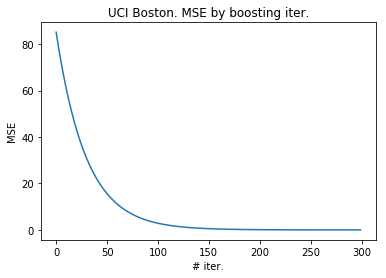

In [31]:
plt.plot(range(len(regr.loss_by_iter)), regr.loss_by_iter);
plt.xlabel('# iter.')
plt.ylabel('MSE');
plt.title('UCI Boston. MSE by boosting iter.');

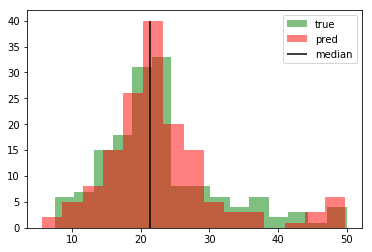

In [32]:
plt.hist(y_test, alpha=0.5, color='green', label='true', bins=15);
plt.hist(regr.predict(X_test), alpha=0.5, color='red', label='pred', bins=15);
plt.vlines(x=np.median(y_test), ymin=0, ymax=40, label='median');
plt.legend();

- Обучите регрессор `GradientBoosting` с функцией потерь `MSE` и параметрами `learning_rate`=3,  `max_depth`=10 - 300 итераций
- Посмотрите на изменение функции потерь по итерациям бустинга
- Сделайте прогнозы для отложенной выборки
- Постройте распределение ответов `y_test` на отложенной выборке и наложите на него распределение ответов бустинга `test_pred`. Используйте метод `hist` из `matplotlib.pyplot` с параметром `bins=15`

<font color='red'>Вопрос 5.</font> Выберите верное утверждение про гистограммы:
1. Ответы бустинга в среднем завышены на 10 
2. В бине, в который попадает медиана ответов на тестовой выборке (`numpy.median(y_test)`), больше значений из вектора прогнозов `test_pred`, чем из вектора ответов `y_test`
3. Бустинг иногда прогнозирует значения, сильно выпадающие за диапазон изменения ответов `y_test`
   <br><br>
 <font color='red'>Ответ: 2.</font>

## Классификация с UCI breast cancer

In [33]:
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

In [35]:
clf = GradientBoosting(n_estimators=200, loss='log_loss', max_depth=3,
                      learning_rate=0.01)
clf.fit(X_train, y_train)

GradientBoosting(debug=False, learning_rate=0.01, loss=None, max_depth=3,
         n_estimators=200, random_state=17)

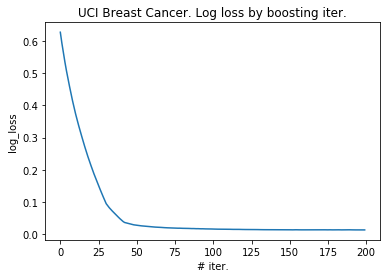

In [36]:
plt.plot(range(len(clf.loss_by_iter)), clf.loss_by_iter);
plt.xlabel('# iter.')
plt.ylabel('log_loss');
plt.title('UCI Breast Cancer. Log loss by boosting iter.');

In [37]:
pred_probs = clf.predict_proba(X_train)

Гистограммы предсказанных вероятностей отнесения к классу "+" для положительных и отрицательных объектов обучающей выборки.

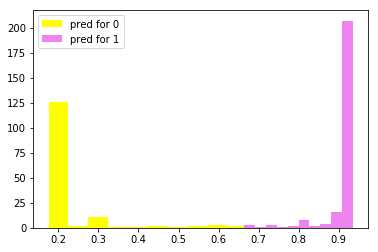

In [38]:
plt.hist(pred_probs[y_train == 0], color='yellow', label='pred for 0');
plt.hist(pred_probs[y_train == 1], color='violet', label='pred for 1');
plt.legend();

**ROC AUC и доля правильных ответов на отложенной выборке.**

In [39]:
roc_auc_score(y_test, clf.predict_proba(X_test)), accuracy_score(y_test, clf.predict(X_test))

(0.98852459016393435, 0.9707602339181286)

Обучите классификатор `GradientBoosting` с функцией потерь `log_loss` и параметрами `learning_rate`=0.01,  `max_depth`=3 - 200 итераций. Посмотрите на изменение функции потерь по итерациям бустинга. Сделайте прогнозы для отложенной выборки – как предсказанные вероятности отнесения к классу +1, так и бинарные прогнозы. Посчитайте ROC AUC для прогноза в виде вероятностей и долю правильных ответов для прогноза в виде меток классов.

<font color='red'>Вопрос 6.</font> Каковы получаются ROC AUC и доля правильных ответов на отложенной выборке `(X_test, y_test)`?
1. 0.99 и 0.97
2. 1 и 0.97
3. 0.98 и 0.96
4. 0.97 и 0.95
 <br><br>
 <font color='red'>Ответ: 1.</font>